In [1]:
import numpy as np 
import os 
from matplotlib import pyplot as plt 
import nibabel as nib 
import pandas as pd 
import seaborn as sns 
%matplotlib inline 

In [2]:
def true_map_modify(y_true):
    for i in range(len(np.unique(y_true))):
        y_true = np.where(y_true == np.unique(y_true)[i], np.round(np.unique(y_true)[i]), y_true)
    return y_true

In [3]:
def load_data(pat_dir):
    
    true_dir = pat_dir + 'roi.nii.gz'
    pred_dir = pat_dir + 'model-label.nii.gz'
    nib_true, nib_pred = nib.load(true_dir), nib.load(pred_dir)
    true, pred = nib_true.get_fdata(), nib_pred.get_fdata()
    true = true_map_modify(true)

    return true, pred 

In [4]:
def single_dice_coef(y_true, y_pred_bin):
    
    # shape of y_true and y_pred_bin: (height, width)
    classes = np.unique(y_true)[1:]
    dice_coef = np.full(len(classes)+2, float('NaN'))
    dice_mean = 0
    for i in classes:
        intersection = np.sum((y_true == i) * (y_pred_bin == i))
        union = np.sum(y_true == i) + np.sum(y_pred_bin == i)
        dice = (2*intersection) / union
        dice_mean += dice
        dice_coef[int(i-1)] = dice
    
    dice_coef[-1] = dice_mean/len(classes)
    
    # dice_total
    intersection_tot = np.sum((y_true > 0) * (y_pred_bin > 0))
    union_tot = np.sum(y_true > 0) + np.sum(y_pred_bin > 0)
    dice_tot = (2*intersection_tot) / union_tot
    dice_coef[-2] = dice_tot
    
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    
    return dice_coef

## Load data

In [5]:
def generate_dice_array(pat_list, task):
    dice_classes = []
    for i in range(len(pat_list)):
        patient = root + task + pat_list[i] + "/"
        true, pred = load_data(patient) 
        dice_class = single_dice_coef(true, pred) 
        dice_classes.append(dice_class)
    return dice_classes

In [6]:
def generate_task_df(dice_classes, task:str, column_name:list):
    '''
    brain tumor: columns = ['edema','non-enhancing tumor','enhancing tumor','mean']
    '''
    #dice_classes = [np.append(arr,float('NaN')) if len(arr)==2 else arr for arr in dice_classes]
    dice_df = pd.DataFrame(dice_classes, columns=column_name)
    dice_df = pd.melt(dice_df, var_name='ROI_type', value_name = 'dice_coef')
    dice_df['task'] = [task] * len(dice_df)
    
    return dice_df

In [7]:
def specify_task(task:str):
    pat_list = os.listdir(root + task) 
    pat_list = sorted([pat for pat in pat_list if pat[0].isalpha()])
    return pat_list

In [8]:
root = "Patients_Hepatic/" 
# col_names = ['edema','non-enhancing tumor','enhancing tumor','mean']
col_names = ['Vessel','Tumor', 'Vessel+Tumor','mean']

In [10]:
# path = root + 'Val/' + 'Pancreas_367/'
# pred = nib.load(path + 'model-label.nii.gz').get_fdata()
# roi = nib.load(path + 'roi.nii.gz').get_fdata()

In [ ]:
roi = true_map_modify(roi)
np.unique(roi)

In [ ]:
np.where(roi == 2)

In [ ]:
single_dice_coef(roi, pred)

### Train

In [11]:
task = 'Train/'
pat_list = specify_task(task)
dice_classes = generate_dice_array(pat_list, task)
dice_train = generate_task_df(dice_classes, 'train', col_names)

### Validation

In [12]:
task = "Val/"
pat_list = specify_task(task)
dice_classes = generate_dice_array(pat_list, task)
dice_val = generate_task_df(dice_classes, 'validation', col_names)

### Test

In [13]:
task = "Test/"
pat_list = specify_task('Test/')
dice_classes = generate_dice_array(pat_list, task)
dice_test = generate_task_df(dice_classes, 'test', col_names)

### Total

In [14]:
df_dice = pd.concat([dice_train, dice_val, dice_test])

In [3]:
#df_dice.to_csv('dice_hepatic_augment.csv', header=True, index=0)

## Plot

In [25]:
df_dice = pd.read_csv('dice_hepatic_augment.csv')

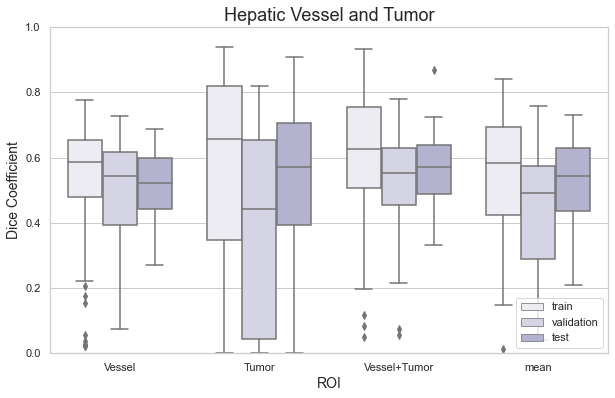

In [28]:
sns.set_style("whitegrid")
sns.set_palette("Purples")
sns.boxplot(x='ROI_type', y='dice_coef', data=df_dice, hue='task', width=0.75)
plt.title('Hepatic Vessel and Tumor', fontsize=18)
plt.xlabel('ROI', fontsize=14)
plt.ylabel('Dice Coefficient',fontsize=14)
plt.ylim([0,1])
plt.legend(loc='lower right')
sns.set(rc={'figure.figsize':(10,6)})